In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [2]:
''' The following shows the result of training various non-nerual network models on a transliterated version of the 
Kannada set transliterated so that all comments are in the Kannada script. models are trained on an tf-idf vectorizer
with dimensionality reduction.'''

' The following shows the result of training various non-nerual network models on a transliterated version of the \nKannada set transliterated so that all comments are in the Kannada script. models are trained on an tf-idf vectorizer\nwith dimensionality reduction.'

In [3]:
# import data
kan_train = pd.read_table("../../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


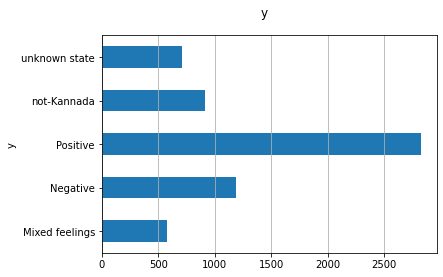

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
# transliterate all data from english scrip to kannada script
from indictrans import Transliterator

# instantiate the trasnliteration
trn = Transliterator(source='eng', target='kan', build_lookup=True)

# save the text column as a list in order to improve performance.
orig_kn_train = (kan_train['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans = []
for i in range(len(orig_kn_train)):
    list_trans.append(trn.transform(orig_kn_train[i]))
    
# append the transliterated texts as a column on original dataframe
kan_train['text_trans'] = list_trans

In [8]:
kan_train_trans = kan_train.drop(['text'], axis=1)
kan_train_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_train_trans

,y,text
0,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...
1,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...
2,not-Kannada,ಸುಪರ್ ಸಾರ ಸೋಂಗ್
3,Negative,ಟೀಕ್ಟೋಕರ್ಸ್ ಪ್ರಸೇಂಟ್ ಸಿತುಂಏಶನ್... ನನೋಡುವವರು ಯಾ...
4,Positive,ಸುಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....
...,...,...
6207,not-Kannada,@ಆ.ರ.ವ್ ಟುಂಬಾದ್ ತನ್ಹಾಜಿ ಅಂಧಾಧುನ ಐಸೆ ಬಹೋತ ಹೈ ...
6208,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്
6209,Negative,ಬ್ರೊ...ನ್ನೀನ್ ಎಸ್ಟೆ ರೋಸ್ತ ಮದುದ್ರು...ಚೀನಾ ನೇ ಬೇ...
6210,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...


In [9]:
# do the same for the dev data
# save the text column as a list in order to improve performance.
orig_kn_dev = (kan_dev['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans_dev = []
for i in range(len(orig_kn_dev)):
    list_trans_dev.append(trn.transform(orig_kn_dev[i]))
    
# append the transliterated texts as a column on original dataframe
kan_dev['text_trans'] = list_trans_dev

In [10]:
kan_dev_trans = kan_dev.drop(['text'], axis=1)
kan_dev_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_dev_trans

,y,text
0,Mixed feelings,ಬಿಂದೂಗೇ ಸರ್ಯಗೀ ಉಗೀಥೀದೀರಾ ಗುಡ್ ಗೋ ಅಹೆಡ್ ವೇ ಅರೇ...
1,Positive,ಯೇನ ಸೋಂಗ್ ಗುರು ...ಸುಪರ್
2,not-Kannada,ಮೀ ಫೆವರತ ಸ್ಟೋರಿ
3,Positive,ಸುಪರ್ ತೋಗರಿ ತೀಪ್ಪ
4,Positive,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
...,...,...
686,Negative,@ನಂದೀ ಪಾರ್ಥಾಸರಥೀ ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687,Negative,ಹುಗೀ ಗುರು ಬದೇತಾಕೆ
688,Positive,ಟ್ರೆಂಡಿಂಗ್ ನೋ.1 ವೋ
689,Positive,@ಟ್ರೋಲ್ ಸ್ತುಪಿಡ್ ಫಂಸ ನಾನು ಆದಿಕಏ ಕಾನೋ ಹೇಲ್ಥೀರೋದ...


In [11]:
# Now we can define our training data and our dev data as well as targets
train = kan_train_trans
test = kan_dev_trans

y_train = kan_train_trans['y'].values
y_test = kan_dev_trans['y'].values


In [12]:
# for ensemble: 
results = pd.DataFrame(kan_dev_trans['y'])

## Using Tf-Idf vectorizer

In [13]:
## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [14]:
# now run thse vectorizers on the train data
corpus = train["text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [15]:
X_train

<6212x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 39145 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Sparse Matrix Sample')

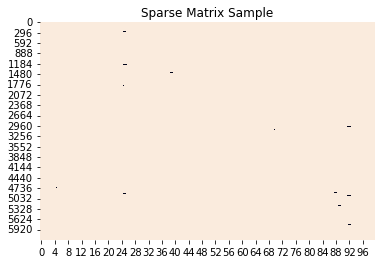

In [16]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## reducing the vectorizers dimensionality

In [17]:
# reduce dimensionality through feature selection

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [18]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Mixed feelings:
  . selected features: 330
  . top features: ಗಮ,ಪರ,ಯವಡ,ಅದ ಪದ,ಗಮ ವದ,32,ಗಮ ಯವಡ,ಗಮ ಇದ,ಅಜಯ,ಬರಬ
 
# Negative:
  . selected features: 200
  . top features: ಪರ,ಸರಥ,ಉರ,ರಶ,ಶತ,ಇಲ,ಮಗನ,ನನ ಮಕ,ಮಕ,_ಕನ
 
# Positive:
  . selected features: 91
  . top features: ಗಡ ಇದ,ದನ ಗಡ,ಗಡ,ಇದ,ಚರ,ಚರ ಅವತ,ಸರಥ,ಪರ,ಇದ ಚರ,ಅವತ
 
# not-Kannada:
  . selected features: 149
  . top features: ಜಲ,ಪರ,ಲವ,ಪರ ಪರ,ಉಪ ಪರ,ಇದ,ಮದ,ಆಮ,ಕಬ,ಕಹ
 
# unknown state:
  . selected features: 240
  . top features: ಪರ,ಪರಮ,ಗಪ,ಜಗದ,ಜಗದ ಬಲ,ಅಪ ಫಣ,ನನಗ ಗಳ,ಪರ 30,ಪರಮ ಇನ,ಕರ ಅಗ
 


## re-fitting the vectorizer on the new vocabulary gained through feature reduction

In [19]:
# we can now refit the vecotrizer on the corpus by giving this new set of words as input.
# producing a smaller feature matrix and a shorter vocabulary.
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [20]:
X_train.shape

(6212, 926)

Text(0.5, 1.0, 'Sparse Matrix Sample')

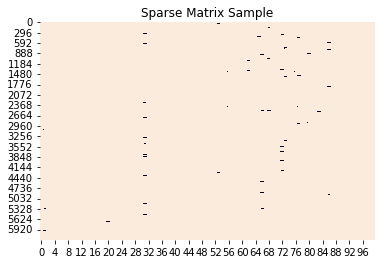

In [21]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Training a cat boost classifier

In [22]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    iterations=500, 
    learning_rate=1.5, 
    #loss_function='CrossEntropy'
)


In [23]:
## pipeline
model_cat = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", cat)])
## train classifier
model_cat["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_cat.predict(X_test)
results['cat_boost_trans_tfidf'] = predicted
predicted_prob = model_cat.predict_proba(X_test)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.4944665	total: 81.3ms	remaining: 40.6s
1:	learn: 1.4270616	total: 101ms	remaining: 25.1s
2:	learn: 1.3665596	total: 120ms	remaining: 19.9s
3:	learn: 1.3389414	total: 140ms	remaining: 17.4s
4:	learn: 1.3122850	total: 160ms	remaining: 15.8s
5:	learn: 1.2890591	total: 179ms	remaining: 14.8s
6:	learn: 1.2681669	total: 200ms	remaining: 14.1s
7:	learn: 1.2498917	total: 220ms	remaining: 13.5s
8:	learn: 1.2383508	total: 240ms	remaining: 13.1s
9:	learn: 1.2224761	total: 259ms	remaining: 12.7s
10:	learn: 1.2065473	total: 279ms	remaining: 12.4s
11:	learn: 1.1990759	total: 299ms	remaining: 12.2s
12:	learn: 1.1881472	total: 319ms	remaining: 11.9s
13:	learn: 1.1811023	total: 338ms	remaining: 11.7s
14:	learn: 1.1746034	total: 358ms	remaining: 11.6s
15:	learn: 1.1687160	total: 377ms	remaining: 11.4s
16:	learn: 1.1618984	total: 397ms	remaining: 11.3s
17:	learn: 1.1567457	total: 416ms	remaining: 11.1s
18:	learn: 1.1465379	total: 436ms	remaining: 11s
19:	learn: 1.1416696	total: 455ms	remainin

165:	learn: 0.9273580	total: 3.33s	remaining: 6.7s
166:	learn: 0.9264610	total: 3.35s	remaining: 6.68s
167:	learn: 0.9258962	total: 3.37s	remaining: 6.66s
168:	learn: 0.9252231	total: 3.39s	remaining: 6.64s
169:	learn: 0.9244222	total: 3.41s	remaining: 6.62s
170:	learn: 0.9237122	total: 3.43s	remaining: 6.6s
171:	learn: 0.9230410	total: 3.45s	remaining: 6.58s
172:	learn: 0.9224284	total: 3.47s	remaining: 6.55s
173:	learn: 0.9212113	total: 3.49s	remaining: 6.53s
174:	learn: 0.9204588	total: 3.51s	remaining: 6.51s
175:	learn: 0.9194398	total: 3.53s	remaining: 6.49s
176:	learn: 0.9188691	total: 3.55s	remaining: 6.47s
177:	learn: 0.9184102	total: 3.57s	remaining: 6.45s
178:	learn: 0.9180390	total: 3.59s	remaining: 6.43s
179:	learn: 0.9176670	total: 3.6s	remaining: 6.41s
180:	learn: 0.9172630	total: 3.63s	remaining: 6.39s
181:	learn: 0.9164450	total: 3.64s	remaining: 6.37s
182:	learn: 0.9155269	total: 3.66s	remaining: 6.35s
183:	learn: 0.9151658	total: 3.68s	remaining: 6.33s
184:	learn: 0.9

330:	learn: 0.8530473	total: 6.58s	remaining: 3.36s
331:	learn: 0.8528059	total: 6.6s	remaining: 3.34s
332:	learn: 0.8521392	total: 6.62s	remaining: 3.32s
333:	learn: 0.8519969	total: 6.64s	remaining: 3.3s
334:	learn: 0.8517348	total: 6.66s	remaining: 3.28s
335:	learn: 0.8515776	total: 6.68s	remaining: 3.26s
336:	learn: 0.8511966	total: 6.7s	remaining: 3.24s
337:	learn: 0.8507880	total: 6.72s	remaining: 3.22s
338:	learn: 0.8497506	total: 6.74s	remaining: 3.2s
339:	learn: 0.8490825	total: 6.76s	remaining: 3.18s
340:	learn: 0.8489114	total: 6.78s	remaining: 3.16s
341:	learn: 0.8482390	total: 6.8s	remaining: 3.14s
342:	learn: 0.8479579	total: 6.82s	remaining: 3.12s
343:	learn: 0.8478148	total: 6.84s	remaining: 3.1s
344:	learn: 0.8472989	total: 6.86s	remaining: 3.08s
345:	learn: 0.8471275	total: 6.88s	remaining: 3.06s
346:	learn: 0.8467078	total: 6.9s	remaining: 3.04s
347:	learn: 0.8464660	total: 6.92s	remaining: 3.02s
348:	learn: 0.8462580	total: 6.93s	remaining: 3s
349:	learn: 0.8461544	

493:	learn: 0.8160640	total: 9.8s	remaining: 119ms
494:	learn: 0.8156904	total: 9.82s	remaining: 99.2ms
495:	learn: 0.8149964	total: 9.84s	remaining: 79.3ms
496:	learn: 0.8148410	total: 9.86s	remaining: 59.5ms
497:	learn: 0.8142000	total: 9.88s	remaining: 39.7ms
498:	learn: 0.8141291	total: 9.9s	remaining: 19.8ms
499:	learn: 0.8139497	total: 9.92s	remaining: 0us


Accuracy: 0.52
Auc: 0.72
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.18      0.08      0.11        52
      Negative       0.53      0.47      0.50       139
      Positive       0.54      0.80      0.64       321
   not-Kannada       0.54      0.26      0.35       110
 unknown state       0.25      0.06      0.09        69

      accuracy                           0.52       691
     macro avg       0.41      0.33      0.34       691
  weighted avg       0.48      0.52      0.47       691



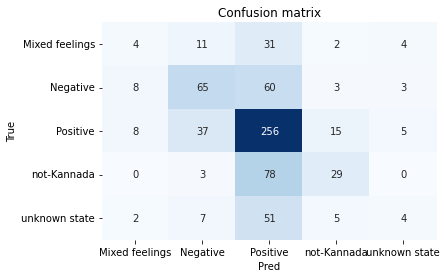

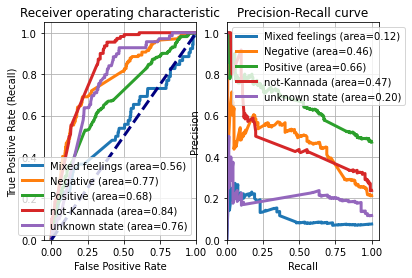

In [24]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=926)

In [26]:
## pipeline
model_forest = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", forest)])
## train classifier
model_forest["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_forest.predict(X_test)
results['forest_trans_tfidf'] = predicted
predicted_prob = model_forest.predict_proba(X_test)

Accuracy: 0.54
Auc: 0.73
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.55      0.12      0.19        52
      Negative       0.56      0.44      0.49       139
      Positive       0.54      0.84      0.66       321
   not-Kannada       0.55      0.30      0.39       110
 unknown state       0.21      0.04      0.07        69

      accuracy                           0.54       691
     macro avg       0.48      0.35      0.36       691
  weighted avg       0.51      0.54      0.49       691



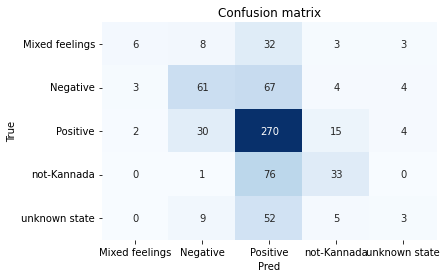

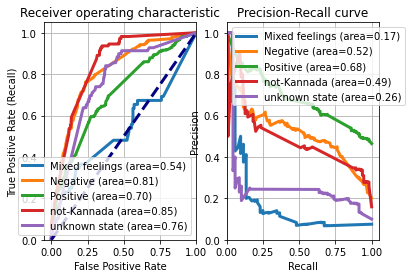

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [28]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 1000)

In [29]:
## pipeline
model_log = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", log)])
## train classifier
model_log["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_log.predict(X_test)
results['logistic_reg_trans_tfidf'] = predicted
predicted_prob = model_log.predict_proba(X_test)

Accuracy: 0.54
Auc: 0.77
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.40      0.04      0.07        52
      Negative       0.57      0.47      0.51       139
      Positive       0.53      0.88      0.66       321
   not-Kannada       0.63      0.20      0.30       110
 unknown state       0.12      0.01      0.03        69

      accuracy                           0.54       691
     macro avg       0.45      0.32      0.31       691
  weighted avg       0.50      0.54      0.47       691



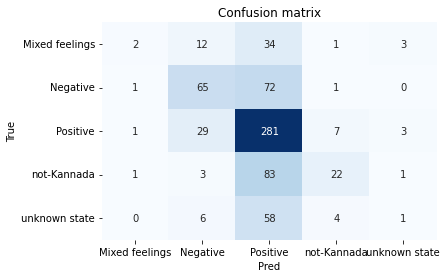

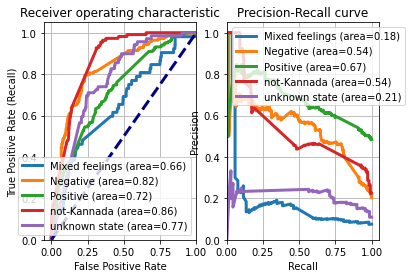

In [30]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
## pipeline
model_neigh = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", neigh)])
## train classifier
model_neigh["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_neigh.predict(X_test)
results['k-nearest_trans_tfidf'] = predicted
predicted_prob = model_neigh.predict_proba(X_test)

Accuracy: 0.48
Auc: 0.68
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.21      0.19      0.20        52
      Negative       0.56      0.45      0.50       139
      Positive       0.53      0.61      0.57       321
   not-Kannada       0.43      0.55      0.49       110
 unknown state       0.17      0.06      0.09        69

      accuracy                           0.48       691
     macro avg       0.38      0.37      0.37       691
  weighted avg       0.46      0.48      0.47       691



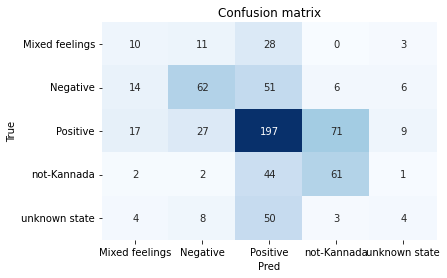

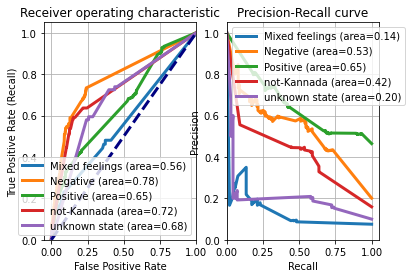

In [33]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble

In [35]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['trabs_majority_label_tfidf'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)
results.to_csv('kan_results_trans_tfidf.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed feelings       0.33      0.08      0.12        52
      Negative       0.56      0.53      0.55       139
      Positive       0.55      0.83      0.66       321
   not-Kannada       0.56      0.25      0.35       110
 unknown state       0.38      0.04      0.08        69

      accuracy                           0.55       691
     macro avg       0.48      0.35      0.35       691
  weighted avg       0.52      0.55      0.49       691



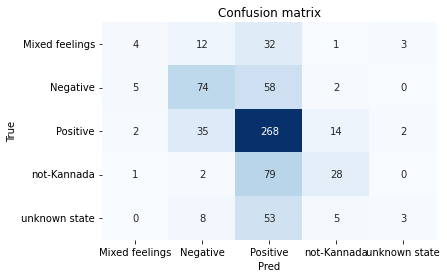

In [38]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['trabs_majority_label_tfidf']))
cm = metrics.confusion_matrix(results['y'], results['trabs_majority_label_tfidf'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()